In [8]:
%matplotlib inline


# Visualizing the stock market structure


This example employs several unsupervised learning techniques to extract
the stock market structure from variations in historical quotes.

The quantity that we use is the daily variation in quote price: quotes
that are linked tend to cofluctuate during a day.

.. _stock_market:

Learning a graph structure
--------------------------

We use sparse inverse covariance estimation to find which quotes are
correlated conditionally on the others. Specifically, sparse inverse
covariance gives us a graph, that is a list of connection. For each
symbol, the symbols that it is connected too are those useful to explain
its fluctuations.

Clustering
----------

We use clustering to group together quotes that behave similarly. Here,
amongst the :ref:`various clustering techniques <clustering>` available
in the scikit-learn, we use :ref:`affinity_propagation` as it does
not enforce equal-size clusters, and it can choose automatically the
number of clusters from the data.

Note that this gives us a different indication than the graph, as the
graph reflects conditional relations between variables, while the
clustering reflects marginal properties: variables clustered together can
be considered as having a similar impact at the level of the full stock
market.

Embedding in 2D space
---------------------

For visualization purposes, we need to lay out the different symbols on a
2D canvas. For this we use :ref:`manifold` techniques to retrieve 2D
embedding.


Visualization
-------------

The output of the 3 models are combined in a 2D graph where nodes
represents the stocks and edges the:

- cluster labels are used to define the color of the nodes
- the sparse covariance model is used to display the strength of the edges
- the 2D embedding is used to position the nodes in the plan

This example has a fair amount of visualization-related code, as
visualization is crucial here to display the graph. One of the challenge
is to position the labels minimizing overlap. For this we use an
heuristic based on the direction of the nearest neighbor along each
axis.


In [9]:
print(__doc__)

# Author: Gael Varoquaux gael.varoquaux@normalesup.org
# License: BSD 3 clause

import datetime

import numpy as np
import matplotlib.pyplot as plt
try:
     from matplotlib.finance import quotes_historical_yahoo_ochl
except ImportError:
     # quotes_historical_yahoo_ochl was named quotes_historical_yahoo before matplotlib 1.4
     from matplotlib.finance import quotes_historical_yahoo as quotes_historical_yahoo_ochl
from matplotlib.collections import LineCollection
from sklearn import cluster, covariance, manifold

Automatically created module for IPython interactive environment


Retrieve the data from Internet


In [10]:
# Choose a time period reasonably calm (not too long ago so that we get
# high-tech firms, and before the 2008 crash)
d1 = datetime.datetime(2003, 1, 1)
d2 = datetime.datetime(2008, 1, 1)

# kraft symbol has now changed from KFT to MDLZ in yahoo
symbol_dict = {
    'TOT': 'Total',
    'XOM': 'Exxon',
    'CVX': 'Chevron',
    'COP': 'ConocoPhillips',
    'VLO': 'Valero Energy',
    'MSFT': 'Microsoft',
    'IBM': 'IBM',
    'TWX': 'Time Warner',
    'CMCSA': 'Comcast',
    'CVC': 'Cablevision',
    'YHOO': 'Yahoo',
    'DELL': 'Dell',
    'HPQ': 'HP',
    'AMZN': 'Amazon',
    'TM': 'Toyota',
    'CAJ': 'Canon',
    'MTU': 'Mitsubishi',
    'SNE': 'Sony',
    'F': 'Ford',
    'HMC': 'Honda',
    'NAV': 'Navistar',
    'NOC': 'Northrop Grumman',
    'BA': 'Boeing',
    'KO': 'Coca Cola',
    'MMM': '3M',
    'MCD': 'Mc Donalds',
    'PEP': 'Pepsi',
    'MDLZ': 'Kraft Foods',
    'K': 'Kellogg',
    'UN': 'Unilever',
    'MAR': 'Marriott',
    'PG': 'Procter Gamble',
    'CL': 'Colgate-Palmolive',
    'GE': 'General Electrics',
    'WFC': 'Wells Fargo',
    'JPM': 'JPMorgan Chase',
    'AIG': 'AIG',
    'AXP': 'American express',
    'BAC': 'Bank of America',
    'GS': 'Goldman Sachs',
    'AAPL': 'Apple',
    'SAP': 'SAP',
    'CSCO': 'Cisco',
    'TXN': 'Texas instruments',
    'XRX': 'Xerox',
    'LMT': 'Lookheed Martin',
    'WMT': 'Wal-Mart',
    'WBA': 'Walgreen',
    'HD': 'Home Depot',
    'GSK': 'GlaxoSmithKline',
    'PFE': 'Pfizer',
    'SNY': 'Sanofi-Aventis',
    'NVS': 'Novartis',
    'KMB': 'Kimberly-Clark',
    'R': 'Ryder',
    'GD': 'General Dynamics',
    'RTN': 'Raytheon',
    'CVS': 'CVS',
    'CAT': 'Caterpillar',
    'DD': 'DuPont de Nemours'}

symbols, names = np.array(list(symbol_dict.items())).T

quotes = [quotes_historical_yahoo_ochl(symbol, d1, d2, asobject=True)
          for symbol in symbols]

open = np.array([q.open for q in quotes]).astype(np.float)
close = np.array([q.close for q in quotes]).astype(np.float)

# The daily variations of the quotes are what carry most information
variation = close - open

Learn a graphical structure from the correlations


In [11]:
edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
edge_model.fit(X)

GraphLassoCV(alphas=4, assume_centered=False, cv=None, enet_tol=0.0001,
       max_iter=100, mode='cd', n_jobs=1, n_refinements=4, tol=0.0001,
       verbose=False)

Cluster using affinity propagation


In [12]:
_, labels = cluster.affinity_propagation(edge_model.covariance_)
n_labels = labels.max()

for i in range(n_labels + 1):
    print('Cluster %i: %s' % ((i + 1), ', '.join(names[labels == i])))

Cluster 1: Kraft Foods
Cluster 2: Pepsi, Coca Cola, Kellogg
Cluster 3: Lookheed Martin, Raytheon, Northrop Grumman, Boeing, General Dynamics
Cluster 4: Comcast, Time Warner, Cablevision
Cluster 5: Apple, Yahoo, Amazon
Cluster 6: Novartis, GlaxoSmithKline, Sanofi-Aventis
Cluster 7: CVS, Walgreen
Cluster 8: Exxon, Chevron, Valero Energy, ConocoPhillips, Total
Cluster 9: Kimberly-Clark, Colgate-Palmolive, Procter Gamble
Cluster 10: Caterpillar, Sony, Navistar, Honda, Xerox, Toyota, Unilever, Mitsubishi, Marriott, Canon
Cluster 11: Ryder, General Electrics, Ford, AIG, Bank of America, Wells Fargo, Mc Donalds, American express, Pfizer, Wal-Mart, DuPont de Nemours, Goldman Sachs, JPMorgan Chase, Home Depot
Cluster 12: Dell, SAP, IBM, Microsoft, HP, 3M, Texas instruments, Cisco


Find a low-dimension embedding for visualization: find the best position of
the nodes (the stocks) on a 2D plane


In [13]:
# We use a dense eigen_solver to achieve reproducibility (arpack is
# initiated with random vectors that we don't control). In addition, we
# use a large number of neighbors to capture the large-scale structure.
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver='dense', n_neighbors=6)

embedding = node_position_model.fit_transform(X.T).T

Visualization


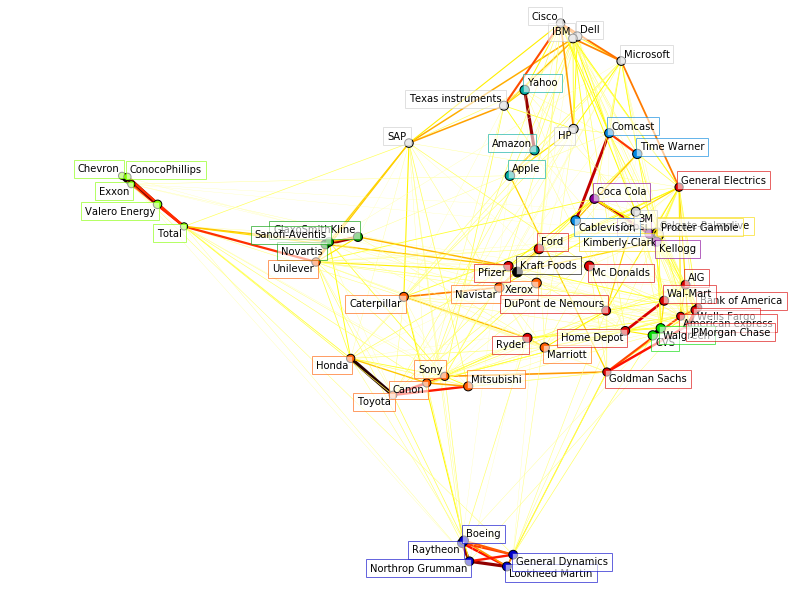

In [14]:
plt.figure(1, facecolor='w', figsize=(10, 8))
plt.clf()
ax = plt.axes([0., 0., 1., 1.])
plt.axis('off')

# Display a graph of the partial correlations
partial_correlations = edge_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = (np.abs(np.triu(partial_correlations, k=1)) > 0.02)

# Plot the nodes using the coordinates of our embedding
plt.scatter(embedding[0], embedding[1], s=100 * d ** 2, c=labels,
            cmap=plt.cm.spectral)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
#a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [[embedding[:, start], embedding[:, stop]]
            for start, stop in zip(start_idx, end_idx)]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(segments,
                    zorder=0, cmap=plt.cm.hot_r,
                    norm=plt.Normalize(0, .7 * values.max()))
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(
        zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = 'left'
        x = x + .002
    else:
        horizontalalignment = 'right'
        x = x - .002
    if this_dy > 0:
        verticalalignment = 'bottom'
        y = y + .002
    else:
        verticalalignment = 'top'
        y = y - .002
    plt.text(x, y, name, size=10,
             horizontalalignment=horizontalalignment,
             verticalalignment=verticalalignment,
             bbox=dict(facecolor='w',
                       edgecolor=plt.cm.spectral(label / float(n_labels)),
                       alpha=.6))

plt.xlim(embedding[0].min() - .15 * embedding[0].ptp(),
         embedding[0].max() + .10 * embedding[0].ptp(),)
plt.ylim(embedding[1].min() - .03 * embedding[1].ptp(),
         embedding[1].max() + .03 * embedding[1].ptp())

plt.show()